# Hypertune cifar10

In [1]:
DATADIR = ("data/raw/cifar10/")

In [2]:
from torchvision import datasets, transforms
from loguru import logger
from pathlib import Path

# Ensure the data directory exists before downloading dataset
data_dir = Path(DATADIR).resolve()
if not data_dir.exists():
    data_dir.mkdir(parents=True)
    logger.info(f"Created {data_dir}")

# Create transformer to convert images to tensors
transformer = transforms.Compose([transforms.ToTensor()])

# Download CIFAR10 dataset
train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transformer)
test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transformer)

logger.info(
    f"Dataset is now available:\n"
    f"TRAIN: {train_dataset}\n"
    f"TEST: {test_dataset}"
)

2025-10-16 16:05:34.652 | INFO     | __main__:<module>:18 - Dataset is now available:
TRAIN: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/data/raw/cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
TEST: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/data/raw/cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [3]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
from torch.utils.data import DataLoader

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Inspect the shape of a batch of training data
for images, labels in train_loader:
    logger.info(f"Image batch dimensions: {images.shape}")
    logger.info(f"Image label dimensions: {labels.shape}")
    break

2025-10-16 16:05:34.694 | INFO     | __main__:<module>:9 - Image batch dimensions: torch.Size([64, 3, 32, 32])
2025-10-16 16:05:34.695 | INFO     | __main__:<module>:10 - Image label dimensions: torch.Size([64])


In [5]:
import torch

config = {
    # Fixed parameters
    "epochs": 5,
    "data_dir": data_dir,
    "batch_size": 64,
    "input_size": 3,
    "output_size": 20,
    "hidden_size": 128,
    "dropout": 0,
    "num_layers": 5,
    "learning_rate": 0.001,
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": torch.optim.Adam,
    # "scheduler": torch.optim.lr_scheduler.LRScheduler,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu", 
}

In [16]:
# Setup for simple neural network with learning curve plotting

import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt

class SimpleNN(nn.Module):
    """
    A simple feedforward neural network for image classification.

    Args:
        input_size (int): Number of input channels (e.g., 3 for RGB images).
        hidden_size (int): Number of units in hidden layers.
        output_size (int): Number of output classes.
        dropout (float): Dropout probability for regularization.
        num_layers (int): Number of hidden layers.

    Methods:
        forward(x): Forward pass through the network.
        summary(): Prints a summary of the network architecture.
        plot_learning_curve(): Plots the learning curve (loss and accuracy).
    """
    def __init__(self, input_size, hidden_size, output_size, dropout, num_layers, use_residual=False, use_batchnorm=False):
        super(SimpleNN, self).__init__()
        self.input_size = input_size
        self.use_residual = use_residual
        self.use_batchnorm = use_batchnorm
        # For learning curve
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        layers = []
        # Flatten input image
        layers.append(nn.Flatten())
        # First linear layer from input to hidden
        layers.append(nn.Linear(input_size * 32 * 32, hidden_size))
        if self.use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))

        # Additional hidden layers with optional residual and batchnorm
        for i in range(num_layers - 1):
            linear = nn.Linear(hidden_size, hidden_size)
            block = [linear]
            if self.use_batchnorm:
                block.append(nn.BatchNorm1d(hidden_size))
            block.append(nn.ReLU())
            block.append(nn.Dropout(dropout))
            if self.use_residual:
                # Residual block as a custom nn.Module
                block = [ResidualBlock(hidden_size, block)]
            layers.extend(block)

        # Output layer
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)


    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size, 32, 32).

        Returns:
            torch.Tensor: Output logits.
        """
        return self.network(x) 

    def summary(self):
        """
        Prints a summary of the network architecture using torchsummary.
        """
        summary(self.network, (self.input_size, 32, 32))

    def plot_learning_curve(self):
        """
        Plots the learning curve (loss and accuracy).
        """
        epochs = range(1, len(self.train_losses) + 1)
        fig, ax1 = plt.subplots()
        ax1.plot(epochs, self.train_losses, 'b-', label='Train Loss')
        ax1.plot(epochs, self.val_losses, 'r-', label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper left')
        ax2 = ax1.twinx()
        ax2.plot(epochs, self.train_accuracies, 'b--', label='Train Acc')
        ax2.plot(epochs, self.val_accuracies, 'r--', label='Val Acc')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='upper right')
        plt.title('Learning Curve')
        plt.show()

class ResidualBlock(nn.Module):
    def __init__(self, hidden_size, block_layers):
        super().__init__()
        self.block = nn.Sequential(*block_layers)
        self.hidden_size = hidden_size

    def forward(self, x):
        return x + self.block(x)


model_NN = SimpleNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["output_size"],
    dropout=config["dropout"],
    num_layers=config["num_layers"]
)
model_NN_with_residual = SimpleNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["output_size"],
    dropout=config["dropout"],
    num_layers=config["num_layers"],
    use_residual=True
)
model_NN_with_batchnorm = SimpleNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["output_size"],
    dropout=config["dropout"],
    num_layers=config["num_layers"],
    use_batchnorm=True
)

# Show a summary of the model architecture
model_NN.summary(); model_NN_with_residual.summary(); model_NN_with_batchnorm.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 3072]                --
├─Linear: 1-2                            [-1, 128]                 393,344
├─ReLU: 1-3                              [-1, 128]                 --
├─Dropout: 1-4                           [-1, 128]                 --
├─Linear: 1-5                            [-1, 128]                 16,512
├─ReLU: 1-6                              [-1, 128]                 --
├─Dropout: 1-7                           [-1, 128]                 --
├─Linear: 1-8                            [-1, 128]                 16,512
├─ReLU: 1-9                              [-1, 128]                 --
├─Dropout: 1-10                          [-1, 128]                 --
├─Linear: 1-11                           [-1, 128]                 16,512
├─ReLU: 1-12                             [-1, 128]                 --
├─Dropout: 1-13                          [-1, 128]                 -

In [18]:
from tqdm import tqdm

def train_and_evaluate(model, train_loader, test_loader, config, logger):
    device = config["device"]
    model.to(device)
    optimizer = config["optimizer"](model.parameters(), lr=config["learning_rate"])
    loss_fn = config["loss_fn"]
    num_epochs = config["epochs"]

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = test_loss / len(test_loader)
        val_accuracy = 100 * correct / total

        # Store for plotting using model's attributes (self)
        model.train_losses.append(avg_loss)
        model.val_losses.append(val_loss)
        model.train_accuracies.append(train_accuracy)
        model.val_accuracies.append(val_accuracy)

        logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Test Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {val_accuracy:.2f}%")

    return model.train_losses[-1], model.val_losses[-1], model.val_accuracies[-1]


Epoch 1/5: 100%|██████████| 782/782 [00:05<00:00, 142.11it/s]
2025-10-16 16:13:13.927 | INFO     | __main__:train_and_evaluate:51 - Epoch [1/5], Train Loss: 1.9651, Test Loss: 1.7665, Train Acc: 26.98%, Test Acc: 36.38%
Epoch 2/5: 100%|██████████| 782/782 [00:08<00:00, 93.68it/s] 
2025-10-16 16:13:23.524 | INFO     | __main__:train_and_evaluate:51 - Epoch [2/5], Train Loss: 1.7497, Test Loss: 1.6823, Train Acc: 36.55%, Test Acc: 39.15%
Epoch 3/5: 100%|██████████| 782/782 [00:07<00:00, 105.98it/s]
2025-10-16 16:13:32.151 | INFO     | __main__:train_and_evaluate:51 - Epoch [3/5], Train Loss: 1.6643, Test Loss: 1.6341, Train Acc: 39.63%, Test Acc: 40.95%
Epoch 4/5: 100%|██████████| 782/782 [00:11<00:00, 69.73it/s] 
2025-10-16 16:13:44.607 | INFO     | __main__:train_and_evaluate:51 - Epoch [4/5], Train Loss: 1.6078, Test Loss: 1.6239, Train Acc: 42.10%, Test Acc: 41.51%
Epoch 5/5: 100%|██████████| 782/782 [00:12<00:00, 63.54it/s]
2025-10-16 16:13:58.158 | INFO     | __main__:train_and_eva

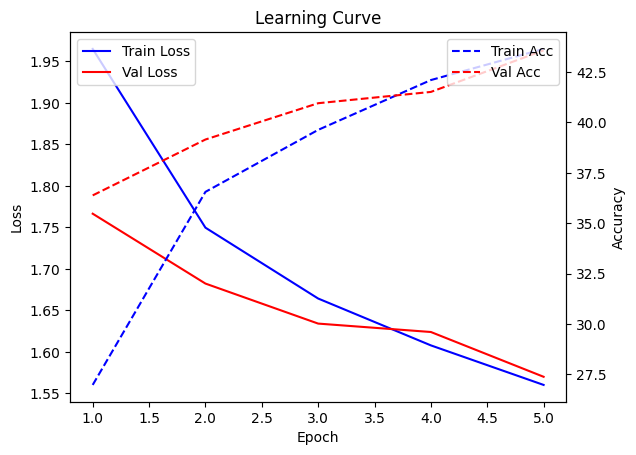

In [19]:
train_and_evaluate(model_NN, train_loader, test_loader, config, logger)
model_NN.plot_learning_curve()

Epoch 1/5: 100%|██████████| 782/782 [00:06<00:00, 128.13it/s]
2025-10-16 16:14:15.343 | INFO     | __main__:train_and_evaluate:51 - Epoch [1/5], Train Loss: 1.8571, Test Loss: 1.7384, Train Acc: 32.89%, Test Acc: 37.44%
Epoch 2/5: 100%|██████████| 782/782 [00:08<00:00, 90.90it/s] 
2025-10-16 16:14:25.179 | INFO     | __main__:train_and_evaluate:51 - Epoch [2/5], Train Loss: 1.6734, Test Loss: 1.6735, Train Acc: 39.96%, Test Acc: 39.49%
Epoch 3/5: 100%|██████████| 782/782 [00:11<00:00, 68.50it/s]
2025-10-16 16:14:37.852 | INFO     | __main__:train_and_evaluate:51 - Epoch [3/5], Train Loss: 1.5907, Test Loss: 1.5946, Train Acc: 43.06%, Test Acc: 42.61%
Epoch 4/5: 100%|██████████| 782/782 [00:11<00:00, 67.78it/s]
2025-10-16 16:14:50.639 | INFO     | __main__:train_and_evaluate:51 - Epoch [4/5], Train Loss: 1.5310, Test Loss: 1.5271, Train Acc: 45.35%, Test Acc: 45.00%
Epoch 5/5: 100%|██████████| 782/782 [00:11<00:00, 67.06it/s]
2025-10-16 16:15:03.552 | INFO     | __main__:train_and_evalu

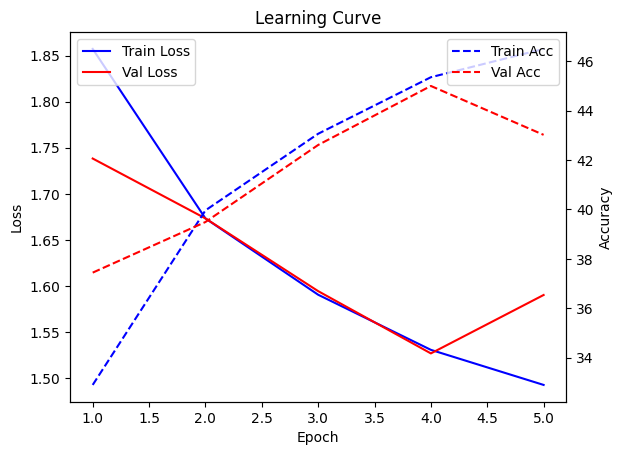

In [20]:
train_and_evaluate(model_NN_with_residual, train_loader, test_loader, config, logger)
model_NN_with_residual.plot_learning_curve()

In [10]:
train_and_evaluate(model_NN_with_batchnorm, train_loader, test_loader, config, logger)

Epoch 1/5: 100%|██████████| 782/782 [00:04<00:00, 172.19it/s]
2025-10-16 16:07:06.171 | INFO     | __main__:train_and_evaluate:33 - Epoch [1/5], Train Loss: 1.6980, Test Loss: 1.6227
Epoch 2/5: 100%|██████████| 782/782 [00:05<00:00, 134.06it/s]
2025-10-16 16:07:13.255 | INFO     | __main__:train_and_evaluate:33 - Epoch [2/5], Train Loss: 1.4769, Test Loss: 1.4934
Epoch 3/5: 100%|██████████| 782/782 [00:05<00:00, 150.39it/s]
2025-10-16 16:07:19.664 | INFO     | __main__:train_and_evaluate:33 - Epoch [3/5], Train Loss: 1.3840, Test Loss: 1.5238
Epoch 4/5: 100%|██████████| 782/782 [00:06<00:00, 113.35it/s]
2025-10-16 16:07:27.814 | INFO     | __main__:train_and_evaluate:33 - Epoch [4/5], Train Loss: 1.3099, Test Loss: 1.7554
Epoch 5/5: 100%|██████████| 782/782 [00:08<00:00, 91.78it/s] 
2025-10-16 16:07:37.583 | INFO     | __main__:train_and_evaluate:33 - Epoch [5/5], Train Loss: 1.2520, Test Loss: 1.3976
2025-10-16 16:07:38.817 | INFO     | __main__:train_and_evaluate:47 - Test Accuracy: 

(1.2519853535820455, 1.3976330324343056, 50.75)

In [11]:
# from mltrainer import Trainer, ReportTypes, TrainerSettings

# model_NN2 = SimpleNN(
#     input_size=config["input_size"],
#     hidden_size=config["hidden_size"],
#     output_size=config["output_size"],
#     dropout=config["dropout"],
#     num_layers=config["num_layers"]
# )

# model_NN2.to(device)

# trainer = Trainer(
#     model=model_NN2,
#     settings=TrainerSettings(
#         epochs=config["epochs"],
#         metrics=[config["metrics"]],
#         logdir=Path("./logs"),
#         train_steps=len(train_loader),
#         valid_steps=len(test_loader),
#         reporttypes=[ReportTypes.TOML],
#         scheduler_kwargs={"patience": 5},
#         earlystop_kwargs={"patience": 5},
#     ),
#     loss_fn=config["loss_fn"],
#     optimizer=torch.optim.Adam,
#     traindataloader=train_loader,
#     validdataloader=test_loader,
#     scheduler=config["scheduler"],
#     device=device,
# )
# trainer.loop()

In [26]:
config2 = {
    # Fixed parameters
    "epochs": 5,
    "data_dir": data_dir,
    "batch_size": 64,
    "input_size": 3,
    "output_size": 20,
    "hidden_size": 128,
    "dropout": 0,
    "num_layers": 3,
    "learning_rate": 0.001,
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": torch.optim.Adam,
    # "scheduler": torch.optim.lr_scheduler.LRScheduler,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    
    # convolutional layer parameters
    "filters": 64,
    "kernel_size": 3,
    "stride": 1,
    "padding": 1,
    
}

In [ ]:
# Setup for simple neural network

import torch.nn as nn
from torchsummary import summary

class SimpleCNN(nn.Module):
    """
    A simple Convolutional Neural Network (CNN) for image classification.

    Args:
        input_size (int): Number of input channels (e.g., 3 for RGB images).
        hidden_size (int): Number of units in the fully connected hidden layer.
        output_size (int): Number of output classes.
        dropout (float): Dropout probability for regularization.
        num_layers (int): Number of convolutional layers.
        filters (int): Number of filters in each convolutional layer.
        kernel_size (int): Size of the convolutional kernels.
        stride (int): Stride for the convolutional layers.
        padding (int): Padding for the convolutional layers.

    Methods:
        forward(x): Forward pass through the network.
        summary(): Prints a summary of the network architecture.
    """
    def __init__(self, input_size, hidden_size, output_size, dropout, num_layers, filters, kernel_size, stride, padding):
        super(SimpleCNN, self).__init__()
        self.input_size = input_size
        # For learning curve
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        layers = []
        in_channels = input_size
        
        # Add convolutional layers
        for _ in range(num_layers):
            layers.append(nn.Conv2d(in_channels, filters, kernel_size, stride, padding))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = filters
        
        layers.append(nn.Flatten())
        # After all convolutional and pooling layers, flatten the output and connect to a fully connected layer.
        # The input features to this layer are: number of filters * (spatial width after pooling) * (spatial height after pooling)
        layers.append(nn.Linear(filters * (32 // (2 ** num_layers)) * (32 // (2 ** num_layers)), hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_size, output_size))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size, 32, 32).

        Returns:
            torch.Tensor: Output logits.
        """
        return self.network(x) 

    def summary(self):
        """
        Prints a summary of the network architecture using torchsummary.
        """
        summary(self.network, (self.input_size, 32, 32))
    
    def plot_learning_curve(self):
        """
        Plots the learning curve (loss and accuracy).
        """
        epochs = range(1, len(self.train_losses) + 1)
        fig, ax1 = plt.subplots()
        ax1.plot(epochs, self.train_losses, 'b-', label='Train Loss')
        ax1.plot(epochs, self.val_losses, 'r-', label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper left')
        ax2 = ax1.twinx()
        ax2.plot(epochs, self.train_accuracies, 'b--', label='Train Acc')
        ax2.plot(epochs, self.val_accuracies, 'r--', label='Val Acc')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='upper right')
        plt.title('Learning Curve')
        plt.show()

model_CNN = SimpleCNN(
    input_size=config2["input_size"],
    hidden_size=config2["hidden_size"],
    output_size=config2["output_size"],
    dropout=config2["dropout"],
    num_layers=config2["num_layers"],
    filters=config2["filters"],
    kernel_size=config2["kernel_size"],
    stride=config2["stride"],
    padding=config2["padding"]
)

# Show a summary of the model architecture
model_CNN.summary(); model_CNN.summary

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─ReLU: 1-2                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-3                         [-1, 64, 16, 16]          --
├─Conv2d: 1-4                            [-1, 64, 16, 16]          36,928
├─ReLU: 1-5                              [-1, 64, 16, 16]          --
├─MaxPool2d: 1-6                         [-1, 64, 8, 8]            --
├─Conv2d: 1-7                            [-1, 64, 8, 8]            36,928
├─ReLU: 1-8                              [-1, 64, 8, 8]            --
├─MaxPool2d: 1-9                         [-1, 64, 4, 4]            --
├─Flatten: 1-10                          [-1, 1024]                --
├─Linear: 1-11                           [-1, 128]                 131,200
├─ReLU: 1-12                             [-1, 128]                 --
├─Dropout: 1-13                          [-1, 128]                 --

<bound method SimpleCNN.summary of SimpleCNN(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=128, bias=True)
    (11): ReLU()
    (12): Dropout(p=0, inplace=False)
    (13): Linear(in_features=128, out_features=20, bias=True)
  )
)>

In [28]:
train_and_evaluate(model_CNN, train_loader, test_loader, config2, logger)
model_CNN.plot_learning_curve()

Epoch 1/5: 100%|██████████| 782/782 [00:19<00:00, 40.34it/s]
2025-10-16 16:18:52.259 | INFO     | __main__:train_and_evaluate:51 - Epoch [1/5], Train Loss: 1.6389, Test Loss: 1.2638, Train Acc: 39.92%, Test Acc: 55.08%
Epoch 2/5: 100%|██████████| 782/782 [00:24<00:00, 32.16it/s]
2025-10-16 16:19:18.539 | INFO     | __main__:train_and_evaluate:51 - Epoch [2/5], Train Loss: 1.1972, Test Loss: 1.0978, Train Acc: 56.95%, Test Acc: 60.41%
Epoch 3/5: 100%|██████████| 782/782 [00:21<00:00, 35.68it/s]
2025-10-16 16:19:42.290 | INFO     | __main__:train_and_evaluate:51 - Epoch [3/5], Train Loss: 1.0088, Test Loss: 0.9810, Train Acc: 64.33%, Test Acc: 65.17%
Epoch 4/5: 100%|██████████| 782/782 [00:23<00:00, 33.08it/s]
2025-10-16 16:20:07.712 | INFO     | __main__:train_and_evaluate:51 - Epoch [4/5], Train Loss: 0.8957, Test Loss: 0.9331, Train Acc: 68.20%, Test Acc: 67.39%
Epoch 5/5: 100%|██████████| 782/782 [00:19<00:00, 39.48it/s]
2025-10-16 16:20:29.307 | INFO     | __main__:train_and_evaluat

AttributeError: 'SimpleCNN' object has no attribute 'plot_learning_curve'

In [15]:
from mltrainer import Trainer, ReportTypes, TrainerSettings, metrics
model_CNN = SimpleNN(
    input_size=config2["input_size"],
    hidden_size=config2["hidden_size"],
    output_size=config2["output_size"],
    dropout=config2["dropout"],
    num_layers=config2["num_layers"]
)

model_CNN.to(config2["device"])

trainer = Trainer(
    model=model_CNN,
    settings=TrainerSettings(
        epochs=config2["epochs"],
        metrics=[
            metrics.Accuracy()
        ],
        logdir=Path("./logs"),
        train_steps=len(train_loader),
        valid_steps=len(test_loader),
        reporttypes=[ReportTypes.TOML],
        scheduler_kwargs={"patience": 5},
        earlystop_kwargs={"patience": 5},
    ),
    loss_fn=config2["loss_fn"],
    optimizer=torch.optim.Adam,
    traindataloader=train_loader,
    validdataloader=test_loader,
    scheduler=config2["scheduler"],
    device=config2["device"],
)
trainer.loop()

2025-10-16 16:10:00.992 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to logs/20251016-161000
2025-10-16 16:10:00.997 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 782/782 [00:07<00:00, 106.39it/s]
2025-10-16 16:10:09.609 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.8835 test 1.7064 metric ['0.2969']
100%|██████████| 782/782 [00:09<00:00, 86.59it/s]
2025-10-16 16:10:20.145 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 1.6808 test 1.6100 metric ['0.3125']
100%|██████████| 782/782 [00:15<00:00, 50.85it/s]
2025-10-16 16:10:37.684 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 1.5836 test 1.5252 metric ['0.4375']
100%|██████████| 782/782 [00:16<00:00, 47.14it/s]
2025-10-16 16:10:56.357 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 1.5195 test 1.4404 metric ['0.4531']
100%|██████████| 782/782 [00:11<00:00, 71.02it/s]
2025-10-16 16:1